# **Phân cụm dữ liệu bằng K-Means**

## **Import thư viện cần thiết**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

## **Đọc dữ liệu**

In [2]:
df = pd.read_csv("../../data/data_processed/data_processed.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
# Tách đặc trưng và nhãn
X = df.drop(columns=["NSP"]).values
# Nhãn
y = df["NSP"].values 

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## **Phân cụm với K-Means**

In [4]:
def kmeans_init_centers(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    D = cdist(X, centers)
    return np.argmin(D, axis=1)

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        Xk = X[labels == k, :]
        if len(Xk) > 0:
            centers[k, :] = np.mean(Xk, axis=0)
        else:  
            centers[k, :] = X[np.random.randint(0, X.shape[0])]
    return centers

def has_converged(centers, new_centers):
    return np.allclose(centers, new_centers)

def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return centers, labels, it


In [5]:
K = 3
centers, labels, it = kmeans(X_scaled, K)

# Đánh giá
y_pred = labels[-1]
ari = adjusted_rand_score(y, y_pred)
print("Adjusted Rand Index (ARI):", round(ari, 4))
sil_score = silhouette_score(X_scaled, y_pred)
print("Silhouette Score:", round(sil_score, 4))
print("Số vòng lặp:", it)
print("Tâm cụm:")
print(centers[-1])

Adjusted Rand Index (ARI): 0.1917
Silhouette Score: 0.1644
Số vòng lặp: 28
Tâm cụm:
[[-0.53617249 -0.38976134  0.73421439  0.54811618  1.6312261   0.52718054
   2.16074145  0.17761247  1.3044854  -0.52937799 -0.82643906  1.12825589
  -1.10175168  0.6344104   0.89366613  0.28715866 -1.52984222 -1.84102481
  -1.54951228  1.71631352 -0.8065839 ]
 [-0.35104008  0.30116496 -0.03877683  0.09315009  0.13133448 -0.0574756
  -0.21374456 -0.46296186  0.33194363 -0.40388788  0.29433831  0.45753979
  -0.54144023  0.10135269  0.34361098  0.18369855 -0.05318775 -0.10004263
  -0.10064953  0.09031558  0.24954046]
 [ 0.58795979 -0.29198469 -0.13341275 -0.25747791 -0.57763017 -0.0574756
  -0.26380035  0.55423537 -0.75534511  0.65459665 -0.17398798 -0.87369138
   0.97555382 -0.28965793 -0.6677269  -0.30932332  0.45123563  0.58961754
   0.51752417 -0.54586205 -0.12102536]]


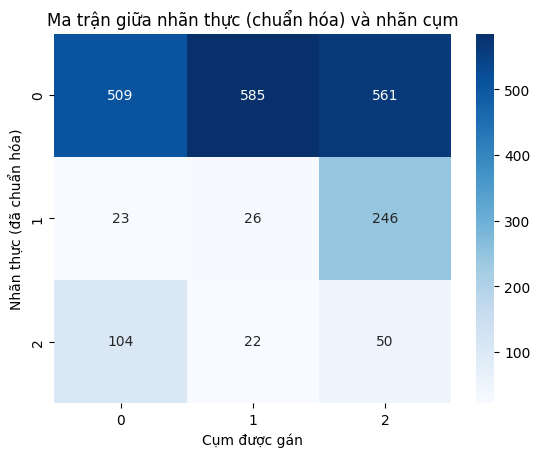

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_adjusted = y - 1
cm = confusion_matrix(y_adjusted, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Cụm được gán")
plt.ylabel("Nhãn thực (đã chuẩn hóa)")
plt.title("Ma trận giữa nhãn thực (chuẩn hóa) và nhãn cụm")
plt.show()


Phân bố phân cụm:
- Nhãn thực 0: 814 mẫu được phân đúng vào cụm 0, nhưng 63 mẫu bị phân sai vào cụm 1 và 102 vào cụm 2.
- Nhãn thực 1: Chỉ 14 mẫu được phân đúng vào cụm 1, với 4 mẫu bị sai vào cụm 0 và 9 vào cụm 2. Điều này cho thấy sự phân tách kém đối với lớp này.
- Nhãn thực 2: 827 mẫu được phân đúng vào cụm 2, nhưng 228 mẫu bị sai vào cụm 1 và 65 vào cụm 0.

Hiệu suất phân cụm:
- Phân cụm hoạt động tốt với nhãn thực 0 và 2, với lần lượt 814 và 827 mẫu đúng. Tuy nhiên, nó gặp khó khăn rõ rệt với nhãn thực 1, chỉ có 14 mẫu được phân đúng.
- Số lượng sai sót cao với nhãn thực 1 (chỉ 14 đúng so với 228 sai từ nhãn thực 2 sang cụm 1) cho thấy các đặc trưng của lớp này có thể không đủ khác biệt sau khi áp dụng PCA, hoặc thuật toán K-means khó phân tách lớp thiểu số này.

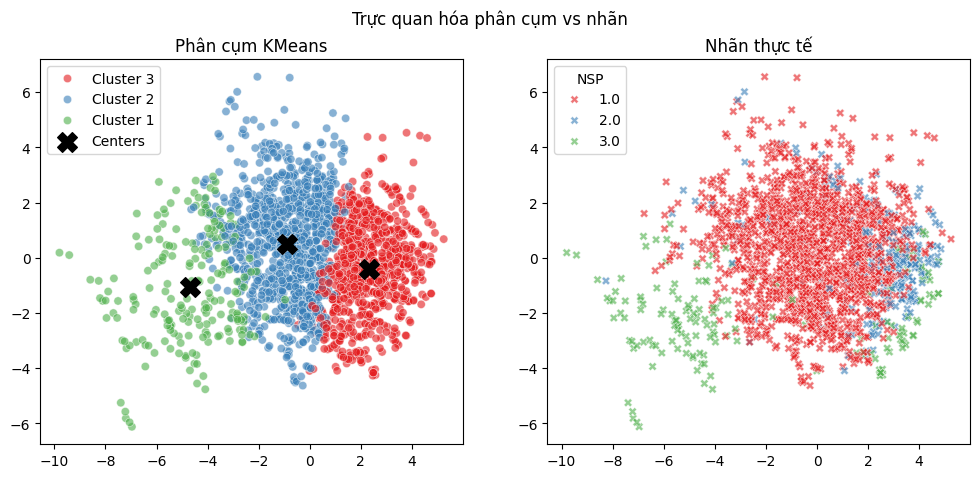

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
y_pred_labels = np.array([f"Cluster {i+1}" for i in y_pred])

# Phân cụm (hue theo nhãn cụm)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred_labels, palette="Set1", alpha=0.6, ax=ax[0])
ax[0].set_title("Phân cụm KMeans")
ax[0].legend(title="Cụm")

# Nhãn thật (hue theo nhãn thực)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1", alpha=0.6, marker="X", ax=ax[1])
ax[1].set_title("Nhãn thực tế")
ax[1].legend(title="NSP")

centers_pca = pca.transform(centers[-1])
ax[0].scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, c='black', marker='X', label='Centers')
ax[0].legend()

plt.suptitle("Trực quan hóa phân cụm vs nhãn")
plt.show()


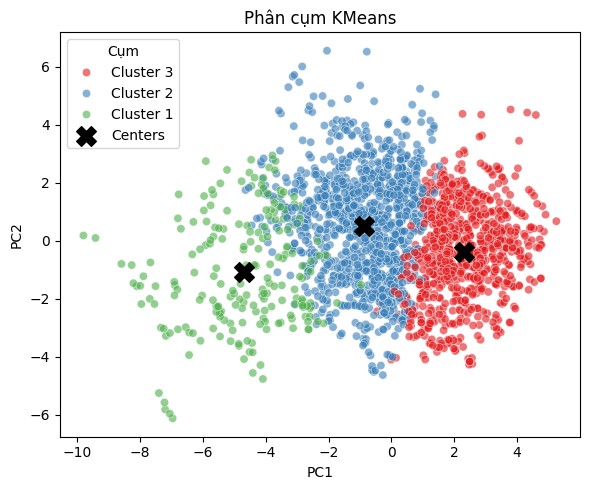

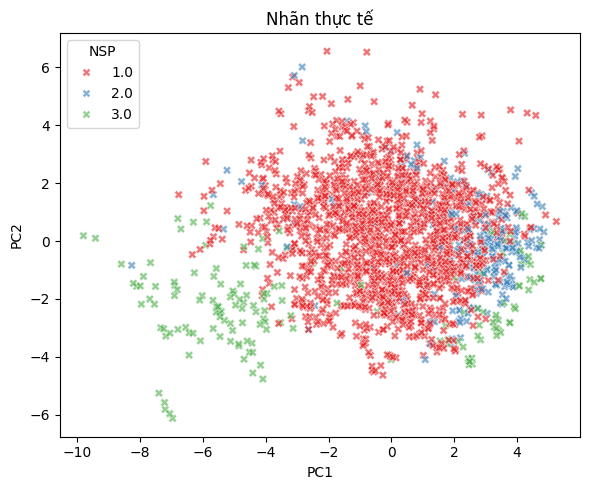

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred_labels = np.array([f"Cluster {i+1}" for i in y_pred])

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred_labels, palette="Set1", alpha=0.6)
centers_pca = pca.transform(centers[-1])
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, c='black', marker='X', label='Centers')
plt.title("Phân cụm KMeans")
plt.legend(title="Cụm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1", alpha=0.6, marker="X")
plt.title("Nhãn thực tế")
plt.legend(title="NSP")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


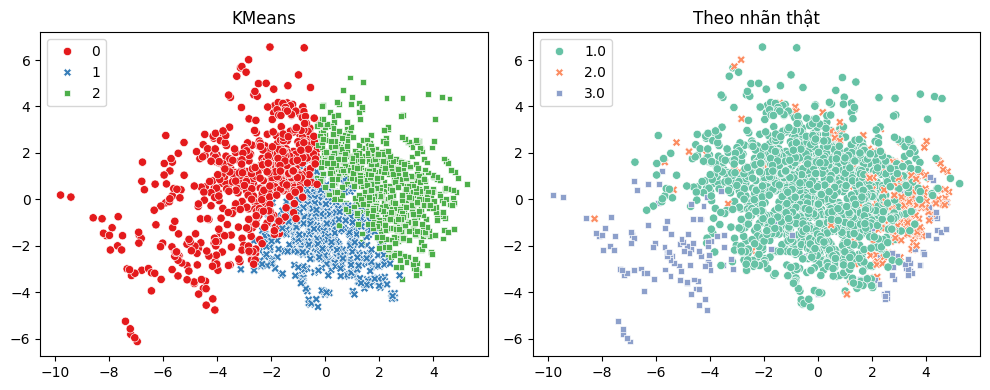

In [39]:
# So sánh nhãn thật vs phân cụm
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_pred, palette="Set1", style=y_pred)
plt.title("KMeans")

plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set2", style=y)
plt.title("Theo nhãn thật")

plt.tight_layout()
plt.show()

1. Đặc điểm phân bố dữ liệu:

- Cụm 0 (màu đỏ): Chiếm ưu thế với khoảng 814 mẫu, phân bố rộng trên không gian 2D
- Cụm 1 (màu xanh dương): Nhỏ nhất với khoảng 63 mẫu, tập trung ở một vùng nhỏ
- Cụm 2 (màu xanh lá): Trung bình với khoảng 102 mẫu, có phân bố tương đối tập trung

2. Mối quan hệ giữa phân cụm và nhãn thực tế:

- ARI = 0.0157 cho thấy độ tương đồng rất thấp giữa kết quả phân cụm và nhãn thực tế

Ma trận nhầm lẫn cho thấy:

- Nhãn 1.0 được phân tán vào tất cả 3 cụm
- Nhãn 2.0 và 3.0 cũng không được phân tách rõ ràng



3. Đánh giá quan hệ giữa đầu vào và đầu ra:

Điểm mạnh:

- Thuật toán K-means hội tụ nhanh (34 vòng lặp)
- Phân cụm tạo ra các nhóm có kích thước khác nhau, phản ánh cấu trúc tự nhiên của dữ liệu

Điểm yếu:

- Độ chồng lấn cao: Các cụm có ranh giới không rõ ràng, đặc biệt giữa cụm 0 và 2
- Phân tách kém theo nhãn: Không có sự tương ứng rõ ràng giữa cụm và nhãn thực tế
- Cấu trúc phức tạp: Dữ liệu có cấu trúc phi tuyến mà K-means không nắm bắt được tốt